In [1]:
from sklearn.datasets import fetch_20newsgroups
import collections
import seaborn as sn
from time import time
import os
import pickle
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from text_rank import Text_rank
import spacy
nlp = spacy.load('en_core_web_sm')
from scipy.sparse import csr_matrix
sn.set()

Including the option greatly effects the model performance (about 10% increase). Model tends to overfit on the metadata.

In [2]:
def get_20newsdata(remove_option, categories):
  return (fetch_20newsgroups(subset='train',  categories=categories, shuffle=True, remove= remove_option, random_state=42),
          fetch_20newsgroups(subset='test', categories=categories, shuffle=True, remove= remove_option, random_state=42))

remove_option = ['headers', 'footers', 'quotes']
categories = None
# remove_option = ()
# categories = ['alt.atheism','talk.religion.misc','comp.graphics','sci.space']
out_dim = len(categories) if categories and len(categories) else 20
data_train, data_test = get_20newsdata(remove_option, categories)

In [3]:
def plot_conv_line(train_acc, test_acc):
  x = np.arange(len(train_acc))
  plt.plot(x, train_acc, label='train_acc')
  plt.plot(x, test_acc, label='test_acc')
  plt.legend()
  plt.show()

In [4]:
def LR(out_dim):
  net = nn.Sequential()
  net.add(nn.Dense(out_dim))
  net.initialize(init.Xavier())
  return net

def evaluate(net, iter):
  corr, n = 0, 0
  for batch in iter:
    X, y = batch
    out = net(X)
    corr += nd.sum(out.argmax(axis=1) == y.astype('float32')).asscalar() 
    n += y.size
    return corr/ n

def train(net, train_iter, test_iter, trainer, loss, num_epoch = 100):
  train_acc, test_acc = [evaluate(net, train_iter)], [evaluate(net, train_iter)]
  
  for i in range(num_epoch):
    start = time()
    for batch in train_iter:
      X, y = batch
      with autograd.record():
        output = net(X)
        l_sum = loss(output, y)
      l_sum.backward()
      trainer.update(len(y))
    train_acc.append(evaluate(net, train_iter))
    test_acc.append(evaluate(net, test_iter))
    print("epoch %d, train acc: %.3f, test acc: %.3f, time: %.3f" 
          % (i+1, train_acc[-1], test_acc[-1], time() - start))
  return (train_acc, test_acc)

Load custom libraries

In [5]:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive')
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [6]:
# uncomment if first time use
# !pip install mxnet-cu101 --target=$nb_path 

import mxnet as mx
from mxnet.gluon import nn, loss as gloss, rnn
from mxnet.gluon import data as gdata
from mxnet import gluon
from mxnet import nd,init
from mxnet.contrib import text
from mxnet import autograd

Dimension after tfidf:

In [8]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df = 5)
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)
X_train.shape, X_test.shape   

((11314, 18092), (7532, 18092))

In [36]:
def prepare_batch(X_train, Y_train, X_test, Y_test, batch_size = 128):
    train_set = gdata.ArrayDataset(nd.array(X_train.toarray()), nd.array(Y_train))
    test_set = gdata.ArrayDataset(nd.array(X_test.toarray()), nd.array(Y_test))
    train_iter = gdata.DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_iter = gdata.DataLoader(test_set, batch_size=batch_size)
    return train_iter, test_iter

In [10]:
train_iter, test_iter = prepare_batch(X_train, data_train.target, X_test, data_test.target)

Training the model

In [11]:
net = LR(out_dim)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 0.1,0, 10
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

epoch 1, train acc: 0.938, test acc: 0.633, time: 0.798
epoch 2, train acc: 0.961, test acc: 0.625, time: 0.765
epoch 3, train acc: 0.977, test acc: 0.609, time: 0.759
epoch 4, train acc: 0.992, test acc: 0.625, time: 0.781
epoch 5, train acc: 0.984, test acc: 0.609, time: 0.771
epoch 6, train acc: 0.977, test acc: 0.625, time: 0.852
epoch 7, train acc: 0.953, test acc: 0.602, time: 0.860
epoch 8, train acc: 0.961, test acc: 0.633, time: 0.788
epoch 9, train acc: 0.961, test acc: 0.609, time: 0.774
epoch 10, train acc: 0.945, test acc: 0.625, time: 0.761


### Using text rank to vectorize data

Extract nouns from training data

In [17]:
def get_tokens(docs, tags = ['NOUN']):
    start = time()
    docs = nlp.pipe([doc.replace('\n', ' ') for doc in docs])
    tokens = [[token.text for token in doc if token.pos_ in tags] for doc in docs]
    print('time: %.3fs' %(time() - start))
    return tokens 

In [20]:
docs_train = get_tokens(data_train.data)

time: 395.512s


In [60]:
vectorizer = CountVectorizer(binary=True, max_df = 0.5, min_df = 5) #set binary to true since we will use text rank
X_train = vectorizer.fit_transform(' '.join([token for token in doc]) for doc in docs_train)

In [61]:
X_train.shape

(11314, 6999)

In [25]:
# vocab = np.array([k for k,v in sorted(vectorizer.vocabulary_.items(), key = lambda x: x[1])])

In [26]:
def get_rk_matrix(rk, vectorizer, docs, shape):
    rows = []
    cols = []
    data = []
    for i, doc in enumerate(docs):
        weight = rk.fit(doc)
        for k,v in weight.items():
            if k in vectorizer.vocabulary_:
                rows.append(i)
                cols.append(vectorizer.vocabulary_[k])
                data.append(v)
    return csr_matrix((data, (rows, cols)), shape = shape)

In [27]:
rk = Text_rank()
rk_mat = get_rk_matrix(rk, vectorizer, docs_train, X_train.shape)
X_train.shape,  rk_mat.shape

((11314, 6999), (11314, 6999))

In [33]:
X_train_rk = normalize(rk_mat, axis=1)
X_train_rk.shape

(11314, 6999)

In [34]:
docs_test = get_tokens(data_test.data)
X_test = vectorizer.transform(' '.join([token for token in doc]) for doc in docs_test)

test_rk_mat = get_rk_matrix(rk, vectorizer, docs_test, X_test.shape)
X_test_rk = normalize(test_rk_mat, axis=1)
X_test_rk.shape

time: 223.705s


(7532, 6999)

In [37]:
train_iter, test_iter = prepare_batch(X_train_rk, data_train.target, X_test_rk, data_test.target)
net = LR(out_dim)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 0.1,0, 10
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

epoch 1, train acc: 0.828, test acc: 0.508, time: 0.593
epoch 2, train acc: 0.883, test acc: 0.523, time: 0.658
epoch 3, train acc: 0.922, test acc: 0.539, time: 0.479
epoch 4, train acc: 0.922, test acc: 0.531, time: 0.476
epoch 5, train acc: 0.922, test acc: 0.516, time: 0.469
epoch 6, train acc: 0.969, test acc: 0.508, time: 0.464
epoch 7, train acc: 0.906, test acc: 0.484, time: 0.478
epoch 8, train acc: 0.938, test acc: 0.484, time: 0.464
epoch 9, train acc: 0.930, test acc: 0.508, time: 0.471
epoch 10, train acc: 0.953, test acc: 0.516, time: 0.587


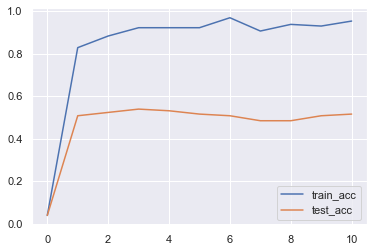

In [38]:
plot_conv_line(train_acc, test_acc)

################################################

See some concrete examples when models get wrong

In [ ]:
def print_top(top=10):
  top = nd.argsort(net[0].weight.data(), axis=1, is_ascend=False)[:, :top]
  top = top.asnumpy().astype('int32')
  names = [[vectorizer.get_feature_names()[idx] for idx in group] for group in top]
  for words, label in zip(names, data_train.target_names):
    print(f"{label}: {', '.join(words)}")
print_top()

alt.atheism: freewill, americans, deletions, guess, thing, impose, certainly, particularly, american, raining
comp.graphics: run, csd, animation, algorithms, result, issue, lab, 2d, hi, gl
sci.space: planets, almost, shuttle, aerospace, spacehab, galaxy, orbital, astronomy, telescope, lockheed
talk.religion.misc: abolish, scope, observation, mr, forever, nevertheless, christian, biological, choice, regardless


In [ ]:
nd.sort(net[0].weight.data(), axis=1, is_ascend=False)[:, :10]


[[19.235493  14.988702  14.681735  14.531059  14.394187  14.300915
  14.282494  14.06204   14.052764  13.966228 ]
 [16.30746   15.271486  14.122896  13.587569  13.160442  12.66065
  12.446225  12.433228  12.137705  12.012    ]
 [16.025364  14.081513  13.506144  13.500292  13.3101635 13.262232
  12.566684  12.345977  12.113235  11.954613 ]
 [16.317327  14.92948   14.877052  14.579246  13.740662  13.463349
  13.094118  13.067143  13.045516  12.907101 ]]
<NDArray 4x10 @cpu(0)>

In [ ]:
def predict(net, docs, label_names, targets = None, vectorizer = None):
  def to_label(yhats):
    return [label_names[i] for i in yhats.astype('int32').tolist()]

  if vectorizer:
    X = vectorizer.transform(docs)
  else:
    X = docs
  X = nd.array(X.toarray())
  out = net(X)
  yhats = out.argmax(axis = 1).asnumpy()
  if targets is not None:
    df = pd.DataFrame({'predict': to_label(yhats), 'target': to_label(targets)})
  else:
    df = pd.DataFrame({'predict': to_label(yhats)})
  return df
  
predict(net, data_test.data[10:20], data_test.target_names, targets=data_test.target[:10], vectorizer=vectorizer)

,predict,target
0,comp.graphics,sci.space
1,comp.graphics,comp.graphics
2,comp.graphics,comp.graphics
3,sci.space,comp.graphics
4,comp.graphics,comp.graphics
5,alt.atheism,comp.graphics
6,alt.atheism,sci.space
7,sci.space,sci.space
8,comp.graphics,alt.atheism
9,sci.space,sci.space


In [ ]:
from sklearn.linear_model import Perceptron
from sklearn import metrics

In [ ]:
def measure(clf, X_train, y_train, X_test, y_test):
  t0 = time.time()
  clf.fit(X_train, y_train)
  train_time = time.time() - t0
  print("train time: %0.3fs" % train_time)

  t0 = time.time()
  pred = clf.predict(X_test)
  test_time = time.time() - t0
  print("test time:  %0.3fs" % test_time)

  score = metrics.accuracy_score(y_test, pred)
  print("accuracy:   %0.3f" % score)
measure(Perceptron(max_iter=50),X_train, data_train.target, X_test, data_test.target)

train time: 0.025s
test time:  0.002s
accuracy:   0.880


Tokenize the data

In [ ]:
token_train = [doc.split() for doc in data_train.data]
token_test = [doc.split() for doc in data_test.data]
counter = collections.Counter(token for doc in token_train for token in doc)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


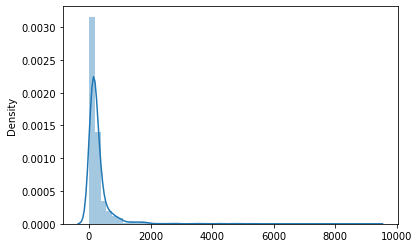

In [ ]:
vocab = text.vocab.Vocabulary(counter, unknown_token='<unknown>', reserved_tokens=['<pad>'])
sns.distplot([len(doc) for doc in  token_train])

In [ ]:
df = pd.DataFrame([len(doc) for doc in  token_train])
df.describe()

,0
count,2034.000000
mean,299.648968
std,561.281536
min,16.000000
25%,107.000000
50%,172.000000
75%,294.000000
max,9168.000000


In [ ]:
# TODO: contains 0 length doc!

In [ ]:
def pad(x, max_l):
    return x[:max_l] if len(x) > max_l else x + [
        vocab.token_to_idx['<pad>']] * (max_l - len(x))

def token2idx(tokens, vocab): 
    indices = []
    max_l = 300   # this is estimated by data distribution
    for doc in tokens:
       indices.append(pad(vocab.to_indices(doc), max_l))
    return indices

X_train = token2idx(token_train, vocab)

X_test = token2idx(token_test, vocab)

In [ ]:
len(token_train), len(token_test)

(2034, 1353)

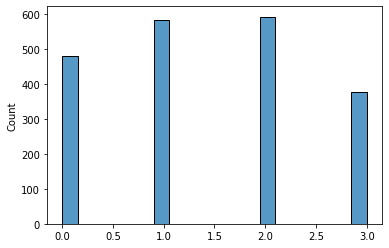

In [ ]:
sns.histplot(data_train.target)

In [ ]:
batch_size = 32

train_set = gdata.ArrayDataset(X_train,data_train.target.tolist())
test_set = gdata.ArrayDataset(X_test, data_test.target.tolist())
train_iter = gdata.DataLoader(train_set, batch_size, shuffle=True)
test_iter = gdata.DataLoader(test_set, batch_size)

net = LR(out_dim)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 0.1,0, 10
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

In [ ]:
class RNN(nn.Block):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers, output_dim, **kwargs):
        super(RNN, self).__init__(**kwargs)
        
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                input_size=embed_size, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(output_dim)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        # outputs = self.encoder(nd.one_hot(inputs.T, len(vocab)))
        outputs = self.encoder(embeddings)
        outs = self.decoder(outputs[-1])
        return self.dropout(outs)

In [ ]:
text.embedding.get_pretrained_file_names('glove')

['glove.42B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'glove.840B.300d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt',
 'glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt']

In [ ]:
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt', vocabulary=vocab)

In [ ]:
glove_embedding.idx_to_token[:10]

['<unknown>', '<pad>', 'the', 'of', 'to', 'a', 'and', 'is', 'that', 'in']

In [ ]:
def evaluate_accuracy(net, iter):
  acc_sum = 0
  n = 0
  for i, batch in enumerate(iter):
    y_hats = net(X)
    acc_sum += (y_hats.argmax(axis=1) == y.astype('float32')).sum().asscalar()
    n += y.size
  # print(acc_sum, n)
  return acc_sum / n

def train(train_iter, test_iter, net, loss, trainer_weight, trainer_bias, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            X,y = batch
            with autograd.record():
                y_hats = net(X)
                ls = loss(y_hats, y)
                ls.backward()
            trainer_weight.step(batch_size)
            trainer_bias.step(batch_size)
            train_l_sum += ls.sum().asscalar()
            n += ls.size
            # train_acc_sum += (y_hats.argmax(axis=1) == y.astype('float32')).sum().asscalar()
            # m += y.size
        # if (epoch+1) % 5 == 0:
        train_acc = evaluate_accuracy(net, train_iter, ctx)
        test_acc = evaluate_accuracy(net, test_iter, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc, test_acc,
                time.time() - start))

In [ ]:
for x,y in train_iter:
  print(x.shape)
  break

(32, 300)


In [ ]:
def get_net():
  embed_size, num_hiddens, num_layers, output_dim, ctx = 100, 20, 1, 4, mx.gpu()
  net = RNN(vocab, embed_size, num_hiddens, num_layers, output_dim)
  net.initialize(init.Xavier(), ctx=ctx, force_reinit=True)
  net.embedding.weight.set_data(glove_embedding.idx_to_vec)
  net.embedding.collect_params().setattr('grad_req', 'null')
  return net


In [ ]:
net = get_net()
evaluate_accuracy(net, train_iter)

MXNetError: ignored

In [ ]:
lr, num_epochs, wd = 0.1, 10, 0
weight_trainer = gluon.Trainer(net.collect_params('.*weight'), 'adam', {'learning_rate': lr, 'wd': wd})
bias_trainer = gluon.Trainer(net.collect_params('.*bias'), 'adam', {'learning_rate': lr})
loss = gloss.SoftmaxCrossEntropyLoss()
train(train_iter, test_iter, net, loss, weight_trainer, bias_trainer, ctx, num_epochs)